In [1]:
import os
import os.path
import glob
from PIL import Image
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import StratifiedKFold                                                                                                                       
from sklearn.metrics import confusion_matrix,accuracy_score
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.model_selection import PredefinedSplit
from sklearn.model_selection import GridSearchCV
import sklearn_evaluation.plot as skplot
from sklearn.model_selection import learning_curve
from sklearn import svm

import matplotlib.pyplot as plt

import numpy as np
np.random.seed(1)

from keras.preprocessing.image import img_to_array
from keras.utils import np_utils
from keras.preprocessing import image
from keras.applications.resnet50 import ResNet50
from keras.applications.imagenet_utils import preprocess_input

os.environ['CUDA_VISIBLE_DEVICES'] = '0'

Using TensorFlow backend.


In [2]:
imagedir = "Datasets/Original"

In [3]:
cur_dir = os.getcwd()
os.chdir(imagedir)  # the parent folder with sub-folders

# Get number of samples per family
list_fams = sorted(os.listdir(os.getcwd()), key=str.lower)  # vector of strings with family names
no_imgs = []  # No. of samples per family
for i in range(len(list_fams)):
    os.chdir(list_fams[i])
    len1 = len(glob.glob('*.ppm'))  # assuming the images are stored as 'ppm'
    no_imgs.append(len1)
    os.chdir('..')
num_samples = np.sum(no_imgs)  # total number of all samples

# Compute the labels
y = np.zeros(num_samples)
pos = 0
label = 0
for i in no_imgs:
    print ("Label:%2d\tClass: %15s\tNumber of images: %d" % (label, list_fams[label], i))
    for j in range(i):
        y[pos] = label
        pos += 1
    label += 1
num_classes = label

# Compute the features
width, height,channels = (224,224,3)
X = np.zeros((num_samples, width, height, channels))
cnt = 0
list_paths = [] # List of image paths
print("Processing images ...")
for i in range(len(list_fams)):
    for img_file in glob.glob(list_fams[i]+'/*.ppm'):
        #print("[%d] Processing image: %s" % (cnt, img_file))
        list_paths.append(os.path.join(os.getcwd(),img_file))
        img = image.load_img(img_file, target_size=(224, 224))
        x = image.img_to_array(img)
        x = np.expand_dims(x, axis=0)
        x = preprocess_input(x)
        X[cnt] = x
        cnt += 1
print("Images processed: %d" %(cnt))

os.chdir(cur_dir)

Label: 0	Class:     fraterculus	Number of images: 100
Label: 1	Class:         obliqua	Number of images: 101
Label: 2	Class:       sororcula	Number of images: 100
Processing images ...
Images processed: 301


In [4]:
X.shape

(301, 224, 224, 3)

In [5]:
# Encoding classes (y) into integers (y_encoded) and then generating one-hot-encoding (Y)
encoder = LabelEncoder()
encoder.fit(y)
y_encoded = encoder.transform(y)
Y = np_utils.to_categorical(y_encoded)

In [6]:
# Creating base_model (ResNet50 notop)
image_shape = (224, 224, 3)                                                                                                                                                                                                                                                                                            
base_model = ResNet50(weights='imagenet', input_shape=image_shape, include_top=False, pooling='avg')

In [7]:
print("Extracting features from ResNet50 layers ...")
resnet50features = base_model.predict(X)

Extracting features from ResNet50 layers ...


In [8]:
resnet50features.shape

(301, 2048)

In [9]:
list_paths

['/home/edmar/GIT/Moscas/Datasets/Original/fraterculus/F035-1,5x.ppm',
 '/home/edmar/GIT/Moscas/Datasets/Original/fraterculus/F025-1,5x.ppm',
 '/home/edmar/GIT/Moscas/Datasets/Original/fraterculus/F084-G-1,5x.ppm',
 '/home/edmar/GIT/Moscas/Datasets/Original/fraterculus/F062-1,5x.ppm',
 '/home/edmar/GIT/Moscas/Datasets/Original/fraterculus/F021-1,5x.ppm',
 '/home/edmar/GIT/Moscas/Datasets/Original/fraterculus/F042-1,5x.ppm',
 '/home/edmar/GIT/Moscas/Datasets/Original/fraterculus/F098-G-1,5x.ppm',
 '/home/edmar/GIT/Moscas/Datasets/Original/fraterculus/F115-G-1,5x.ppm',
 '/home/edmar/GIT/Moscas/Datasets/Original/fraterculus/F048-1,5x.ppm',
 '/home/edmar/GIT/Moscas/Datasets/Original/fraterculus/F010-1,5x.ppm',
 '/home/edmar/GIT/Moscas/Datasets/Original/fraterculus/F022-1,5x.ppm',
 '/home/edmar/GIT/Moscas/Datasets/Original/fraterculus/F006-1,5x.ppm',
 '/home/edmar/GIT/Moscas/Datasets/Original/fraterculus/F055-1,5x.ppm',
 '/home/edmar/GIT/Moscas/Datasets/Original/fraterculus/F110-G-1,5x.ppm'

In [10]:
# Create stratified k-fold subsets                                                                                                                                        
kfold = 5  # no. of folds
skfind = []
test_fold = np.zeros((num_samples,), dtype=int)-1
for i in range(kfold):
    train_ind = []
    print('Datasets/Folds/Fold-Train%d.txt' %(i+1))
    with open('Datasets/Folds/Fold-Train%d.txt' %(i+1), 'r') as f:
        for fname in f.read().splitlines():
            print('[%d] %s' %(list_paths.index([s for s in list_paths if fname in s][0]),fname))
            train_ind.append(list_paths.index([s for s in list_paths if fname in s][0]))
    print('[%d] Train fold size: %d' %(i,len(train_ind)))
    print(train_ind)
    test_ind = []
    print('Datasets/Folds/Fold-Test%d.txt' %(i+1))
    with open('Datasets/Folds/Fold-Test%d.txt' %(i+1), 'r') as f:
        for fname in f.read().splitlines():
            sample_idx = list_paths.index([s for s in list_paths if fname in s][0])
            print('[%d] %s' %(sample_idx,fname))
            test_ind.append(sample_idx)
            test_fold[sample_idx] = i
    print('[%d] Test fold size: %d' %(i,len(test_ind)))
    print(test_ind)
    #skfind.append((np.array(train_ind),np.array(test_ind)))
    skfind.append((train_ind,test_ind))
print('SKFIND')
print(skfind)
print('TEST_FOLD')
print(test_fold)

Datasets/Folds/Fold-Train1.txt
[11] F006-1,5x.ppm
[66] F009-1,5x.ppm
[68] F016,1,5x.ppm
[10] F022-1,5x.ppm
[33] F027-1,5x.ppm
[30] F033-1,5x.ppm
[39] F037-1,5x.ppm
[67] F041-1,5x.ppm
[77] F050-1,5x.ppm
[96] F054-1,5x.ppm
[41] F063-1,5x.ppm
[23] F072-G-1,5x.ppm
[83] F077-G-1,5x.ppm
[18] F090-G-1,5x.ppm
[44] F093-G-1,5x.ppm
[15] F094-G-1,5x.ppm
[63] F095-G-1,5x.ppm
[99] F106-G-1,5x.ppm
[53] F108-G-1,5x.ppm
[47] F132-N-1,5x.ppm
[254] S093-1,5x.ppm
[216] S094-1,5x.ppm
[288] S095-1,5x.ppm
[213] S096-1,5x.ppm
[279] S098-1,5x.ppm
[207] S099-1,5x.ppm
[209] S100-1,5x.ppm
[259] S101-1,5x.ppm
[300] s102-1,5x.ppm
[268] S103-1,5x.ppm
[278] S104-1,5x.ppm
[251] S105-1,5x.ppm
[267] S106-1,5x.ppm
[281] S108-1,5x.ppm
[244] S109-1,5x.ppm
[229] S111-1,5x.ppm
[247] S112-1,5x.ppm
[208] S116-1,5x.ppm
[261] S118-1,5x.ppm
[234] S123-1,5x.ppm
[131] B001-1,5x.ppm
[193] B003,1,5x.ppm
[140] B009-1,5x.ppm
[167] B012-1,5X.ppm
[195] B018-1,5x.ppm
[162] B019-1,5x.ppm
[158] B024-1,5x.ppm
[110] B032-1,5x.ppm
[137] B038-

In [11]:
# Training top_model
C_range = np.logspace(-2, 10, 13)
param_grid = dict(C=C_range)
cv = PredefinedSplit(test_fold)
grid_model = GridSearchCV(svm.LinearSVC(), param_grid=param_grid, cv=cv, verbose=10, n_jobs=-1)
grid_model.fit(resnet50features,y)  # Training 

Fitting 5 folds for each of 13 candidates, totalling 65 fits
[CV] C=0.01 ..........................................................
[CV] C=0.01 ..........................................................
[CV] C=0.01 ..........................................................
[CV] C=0.01 ..........................................................
[CV] C=0.01 ..........................................................
[CV] C=0.1 ...........................................................
[CV] C=0.1 ...........................................................
[CV] C=0.1 ...........................................................
[CV] C=0.1 ...........................................................
[CV] C=0.1 ...........................................................
[CV] C=1.0 ...........................................................
[CV] C=1.0 ...........................................................
[CV] C=1.0 ...........................................................
[CV] C=1.0 .....

[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    1.6s


[CV] ........................... C=0.01, score=0.883333, total=   1.8s
[CV] C=1000.0 ........................................................
[CV] ........................... C=0.01, score=0.933333, total=   1.8s
[CV] C=1000.0 ........................................................
[CV] ........................... C=0.01, score=0.933333, total=   2.1s
[CV] C=1000.0 ........................................................
[CV] ............................ C=1.0, score=0.950000, total=   2.8s
[CV] C=1000.0 ........................................................
[CV] .......................... C=100.0, score=0.850000, total=   2.7s
[CV] C=10000.0 .......................................................
[CV] ............................ C=0.1, score=0.916667, total=   3.1s
[CV] C=10000.0 .......................................................
[CV] ............................ C=1.0, score=0.918033, total=   3.1s
[CV] .......................... C=100.0, score=0.916667, total=   2.9s
[CV] C

[Parallel(n_jobs=-1)]: Done  13 tasks      | elapsed:    3.7s


[CV] ............................ C=0.1, score=0.918033, total=   3.8s
[CV] C=1000000.0 .....................................................
[CV] ........................... C=10.0, score=0.850000, total=   3.7s
[CV] ........................... C=10.0, score=0.950000, total=   3.7s
[CV] C=1000000.0 .....................................................
[CV] C=1000000.0 .....................................................
[CV] ........................... C=10.0, score=0.918033, total=   3.8s
[CV] .......................... C=100.0, score=0.950000, total=   2.8s
[CV] C=1000000.0 .....................................................
[CV] C=1000000.0 .....................................................
[CV] ............................ C=1.0, score=0.916667, total=   3.9s
[CV] C=10000000.0 ....................................................
[CV] ........................... C=10.0, score=0.916667, total=   4.0s
[CV] C=10000000.0 ....................................................
[CV] .

[Parallel(n_jobs=-1)]: Done  25 out of  65 | elapsed:    4.3s remaining:    6.8s


[CV] ......................... C=1000.0, score=0.850000, total=   3.5s
[CV] C=10000000.0 ....................................................
[CV] ......................... C=1000.0, score=0.916667, total=   3.3s
[CV] C=100000000.0 ...................................................
[CV] ........................ C=10000.0, score=0.850000, total=   2.6s
[CV] C=100000000.0 ...................................................
[CV] ......................... C=1000.0, score=0.950000, total=   2.7s
[CV] ......................... C=1000.0, score=0.918033, total=   3.8s
[CV] C=100000000.0 ...................................................
[CV] C=100000000.0 ...................................................
[CV] ........................ C=10000.0, score=0.883333, total=   2.6s
[CV] C=100000000.0 ...................................................
[CV] ......................... C=1000.0, score=0.883333, total=   3.7s
[CV] C=1000000000.0 ..................................................
[CV] .

[Parallel(n_jobs=-1)]: Done  32 out of  65 | elapsed:    5.9s remaining:    6.1s


[CV] ....................... C=100000.0, score=0.918033, total=   2.8s
[CV] C=1000000000.0 ..................................................
[CV] ...................... C=1000000.0, score=0.950000, total=   2.7s
[CV] C=1000000000.0 ..................................................
[CV] ........................ C=10000.0, score=0.918033, total=   3.5s
[CV] C=1000000000.0 ..................................................
[CV] ....................... C=100000.0, score=0.916667, total=   3.1s
[CV] C=10000000000.0 .................................................
[CV] ....................... C=100000.0, score=0.850000, total=   3.4s
[CV] C=10000000000.0 .................................................
[CV] ....................... C=100000.0, score=0.883333, total=   3.4s
[CV] C=10000000000.0 .................................................
[CV] ........................ C=10000.0, score=0.950000, total=   3.6s
[CV] C=10000000000.0 .................................................
[CV] .

[Parallel(n_jobs=-1)]: Done  39 out of  65 | elapsed:    7.1s remaining:    4.8s


[CV] ..................... C=10000000.0, score=0.850000, total=   3.3s
[CV] ...................... C=1000000.0, score=0.883333, total=   3.5s
[CV] ...................... C=1000000.0, score=0.916667, total=   3.6s
[CV] ...................... C=1000000.0, score=0.918033, total=   3.7s
[CV] ..................... C=10000000.0, score=0.883333, total=   3.4s
[CV] ..................... C=10000000.0, score=0.918033, total=   3.5s
[CV] ..................... C=10000000.0, score=0.916667, total=   3.6s


[Parallel(n_jobs=-1)]: Done  46 out of  65 | elapsed:    7.6s remaining:    3.2s


[CV] .................... C=100000000.0, score=0.850000, total=   2.6s
[CV] .................... C=100000000.0, score=0.918033, total=   2.5s
[CV] ..................... C=10000000.0, score=0.950000, total=   3.1s
[CV] .................... C=100000000.0, score=0.950000, total=   2.4s
[CV] .................... C=100000000.0, score=0.916667, total=   2.6s
[CV] ................... C=1000000000.0, score=0.850000, total=   2.5s
[CV] ................... C=1000000000.0, score=0.918033, total=   2.3s
[CV] .................... C=100000000.0, score=0.883333, total=   2.7s


[Parallel(n_jobs=-1)]: Done  53 out of  65 | elapsed:    8.3s remaining:    1.9s


[CV] ................... C=1000000000.0, score=0.916667, total=   2.0s
[CV] ................... C=1000000000.0, score=0.883333, total=   2.0s
[CV] .................. C=10000000000.0, score=0.850000, total=   2.0s
[CV] ................... C=1000000000.0, score=0.950000, total=   2.2s
[CV] .................. C=10000000000.0, score=0.916667, total=   1.9s
[CV] .................. C=10000000000.0, score=0.918033, total=   1.9s
[CV] .................. C=10000000000.0, score=0.883333, total=   1.8s


[Parallel(n_jobs=-1)]: Done  60 out of  65 | elapsed:    8.8s remaining:    0.7s


[CV] .................. C=10000000000.0, score=0.950000, total=   1.9s


[Parallel(n_jobs=-1)]: Done  65 out of  65 | elapsed:    9.2s finished


GridSearchCV(cv=PredefinedSplit(test_fold=array([3, 0, ..., 2, 1])),
       error_score='raise',
       estimator=LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=1000,
     multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
     verbose=0),
       fit_params={}, iid=True, n_jobs=-1,
       param_grid={'C': array([  1.00000e-02,   1.00000e-01,   1.00000e+00,   1.00000e+01,
         1.00000e+02,   1.00000e+03,   1.00000e+04,   1.00000e+05,
         1.00000e+06,   1.00000e+07,   1.00000e+08,   1.00000e+09,
         1.00000e+10])},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=None, verbose=10)

In [12]:
print("Best parameters: %s - score: %0.4f" % (grid_model.best_params_, grid_model.best_score_))

Best parameters: {'C': 0.01} - score: 0.9136


In [13]:
# Training top_model and saving min training loss weights
conf_mat = np.zeros((len(list_fams),len(list_fams))) # Initializing the Confusion Matrix
for i in range(kfold):
    train_indices = skfind[i][0]
    test_indices = skfind[i][1]
    X_train = resnet50features[train_indices]
    y_train = y[train_indices]
    X_test = resnet50features[test_indices]
    y_test = y[test_indices]
    
    top_model = svm.LinearSVC(C=grid_model.best_params_['C'])
    top_model.fit(X_train,y_train)  # Training
    y_pred = top_model.predict(X_test)  # Testing
    print("[%d] Test acurracy: %.4f" %(i,accuracy_score(y_test,y_pred)))
    cm = confusion_matrix(y_test,y_pred)  # Compute confusion matrix for this fold
    conf_mat = conf_mat + cm  # Compute global confusion matrix

[0] Test acurracy: 0.8833
[1] Test acurracy: 0.9180
[2] Test acurracy: 0.9333
[3] Test acurracy: 0.9000
[4] Test acurracy: 0.9333


In [14]:
# Computing the average accuracy
avg_acc = np.trace(conf_mat)/np.sum(conf_mat)
print("Average acurracy: %.4f" %(avg_acc))

Average acurracy: 0.9136


Plotting the confusion matrix


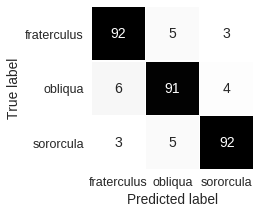

In [15]:
import seaborn as sns
plt.style.use('seaborn-whitegrid')

print("Plotting the confusion matrix")
figure = plt.gcf()
figure.set_size_inches(4, 3)
sns.set(font_scale=1.25)
hm = sns.heatmap(conf_mat, cbar=False, annot=True, square=True,
                 fmt='.0f', annot_kws={'size': 14}, linewidth = 0.2, cmap = 'binary',
                 yticklabels=list_fams, xticklabels=list_fams)
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

Plotting the confusion matrix normalized


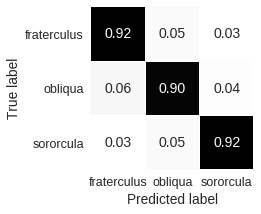

In [16]:
import seaborn as sns
plt.style.use('seaborn-whitegrid')

print("Plotting the confusion matrix normalized")
conf_mat_norm = conf_mat/np.sum(conf_mat,axis=1)  # Normalizing the confusion matrix
conf_mat_norm = np.around(conf_mat_norm,decimals=2)  # rounding to display in figure

figure = plt.gcf()
figure.set_size_inches(4, 3)
sns.set(font_scale=1.25)
hm = sns.heatmap(conf_mat_norm, cbar=False, annot=True, square=True,
                 fmt='.2f', annot_kws={'size': 14}, linewidth = 0.1, cmap = 'binary',
                 yticklabels=list_fams, xticklabels=list_fams)
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

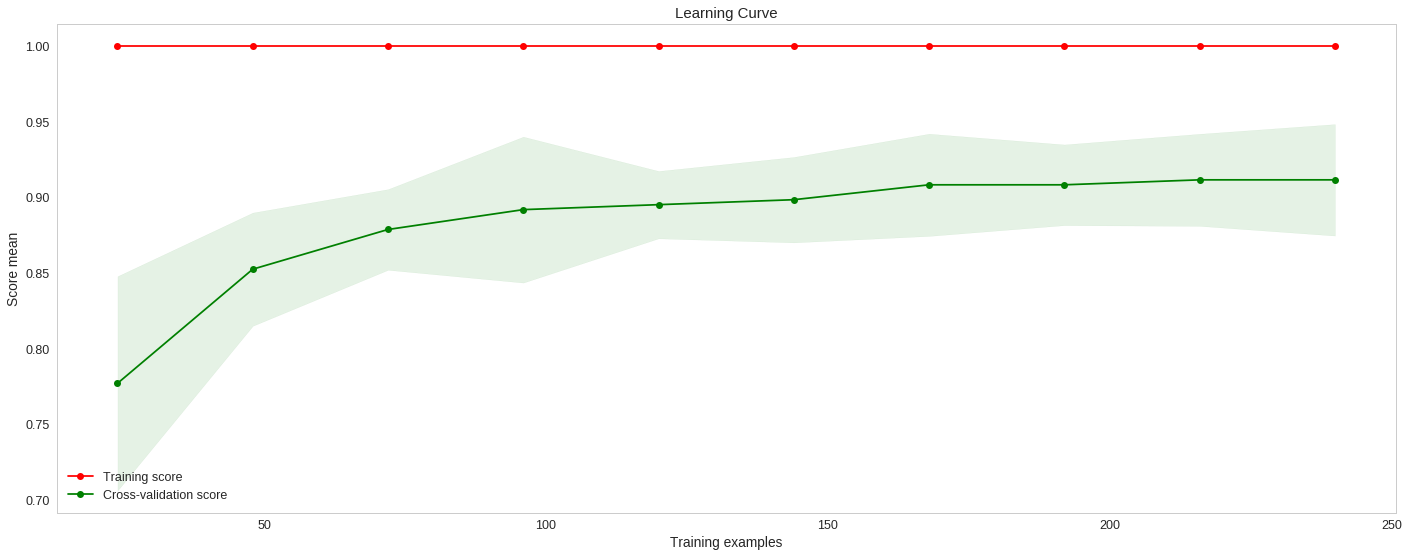

In [17]:
plt.style.use('seaborn-whitegrid')
cv = StratifiedShuffleSplit(n_splits=5, test_size=0.2, random_state=1)
svm_model = svm.LinearSVC(C=grid_model.best_params_['C'])
train_sizes = np.linspace(.1, 1.0, 10)
train_sizes, train_scores, test_scores = learning_curve(svm_model, resnet50features, y, cv=cv, n_jobs=-1, train_sizes=train_sizes)
figure = plt.gcf()
figure.set_size_inches(24, 9)
skplot.learning_curve(train_scores, test_scores, train_sizes)
plt.show()